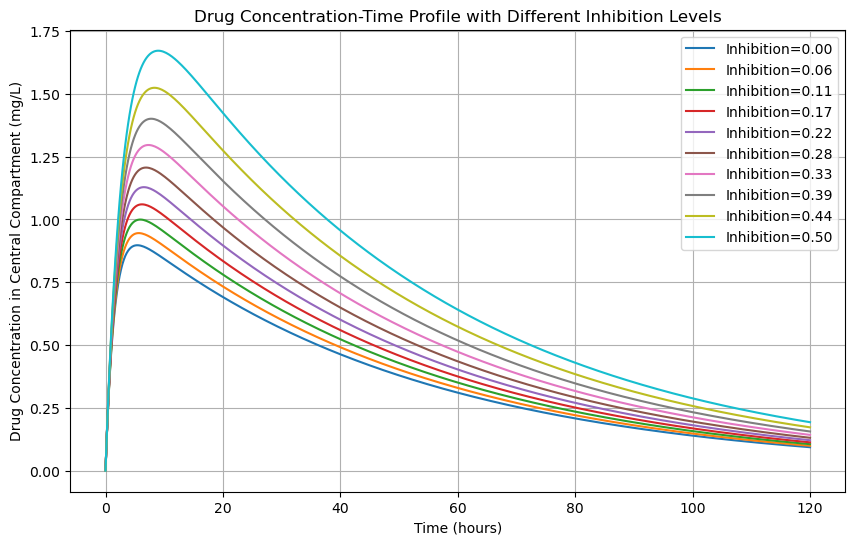

   Inhibition        AUC      Cmax     AUC_we   Cmax_we  RatioAUC_we  RatioAUC
0    0.000000  45.320475  0.897145  51.867357  0.759849     1.000000  1.000000
1    0.055556  47.977667  0.945458  60.748850  0.909075     1.171235  1.058631
2    0.111111  50.965551  0.999361  47.253266  1.355939     0.911041  1.124559
3    0.166667  54.350446  1.059895  63.643754  0.779304     1.227048  1.199247
4    0.222222  58.216595  1.128306  63.131442  0.814294     1.217171  1.284554
5    0.277778  62.674810  1.206258  47.115045  1.183782     0.908376  1.382925
6    0.333333  67.872252  1.296023  45.516808  1.788334     0.877562  1.497607
7    0.388889  74.009374  1.400520  65.993677  1.200863     1.272355  1.633023
8    0.444444  81.365924  1.523704  83.056260  1.409784     1.601320  1.795346
9    0.500000  90.345842  1.671199  94.908384  1.451776     1.829829  1.993488


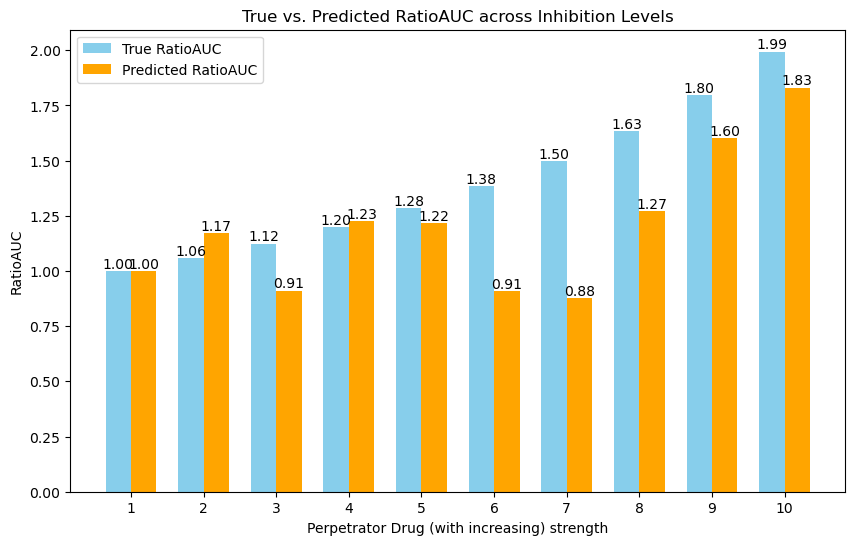

In [25]:
import tellurium as te
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the Antimony model
model = '''
model one_compartment_pk_model
    // Parameters for drug movement
    dose = 100 milligram;           # Initial dose (mg)
    infusiontime = 10 hour;
    k_a0 = dose / infusiontime;     # Zero-order absorption rate (mg/h)
    k_a1 = 0.02 per_hour;           # First-order absorption rate constant (1/h)
    
    CL_base = 2 per_hour;           # Baseline clearance (L/h)
    Vcentral = 3 litre;             # Volume of central compartment (L)
    Vdepot = 1 litre;               # Volume of depot compartment (L)
    
    // Covariate effect on clearance
    Covariate = 1;                 # Covariate multiplier (e.g., could represent renal function)
    
    // Inhibition effect on clearance
    Inhibition = 0;                # Inhibition fraction (0 = no inhibition, 1 = full inhibition)
    
    // Adjusted clearance incorporating covariate and inhibition
    CL := CL_base * Covariate * (1 - Inhibition);

    // Define compartments
    compartment Central, Depot;
    Central := Vcentral;  # Central compartment volume
    Depot := Vdepot;      # Depot compartment volume

    // Define species
    species Drug_Central in Central, Drug_Depot in Depot;

    // Initial conditions
    Drug_Central = 0 milligram_per_litre;   # Initial drug concentration in central compartment
    Drug_Depot = dose / Vdepot;             # Initial drug concentration in depot compartment

    // Reactions for drug movement
    Absorption: Drug_Depot -> Drug_Central; k_a1 * Drug_Depot;  // First-order absorption
    Clearance: Drug_Central -> ; CL * Drug_Central;             # Elimination
    
    // Output
    A_central := Drug_Central * Vcentral;  # Amount of drug in the central compartment (mg)
    
end
'''

# Define simulation parameters
time_end = 24*5  # Simulation time (hours)
num_points = 500  # Number of time points

# Simulate the model for a range of inhibition scenarios by altering the Inhibition parameter
inhibition_values = np.linspace(0, 0.5, 10)  # Range from no inhibition to full inhibition
covariate_value = 1.0  # Can adjust this to simulate different covariate effects
results = []
resultsanalysis=[]

r = te.loada(model)

for inhibition in inhibition_values:
    r.resetAll()
    r["Inhibition"] = inhibition
    r["Covariate"] = covariate_value  # Apply covariate effect (e.g., representing renal function)
    result = r.simulate(0, time_end, num_points)
    results.append((inhibition, result))
    # Calculate AUC and Cmax
    AUC_central = np.trapz(result['[Drug_Central]'], result['time'])
    Cmax_central = np.max(result['[Drug_Central]'])
    # Append the results to the data list
    resultsanalysis.append({'Inhibition': inhibition, 'AUC': AUC_central, 'Cmax': Cmax_central})

# Plotting the results
plt.figure(figsize=(10, 6))
for inhibition, result in results:
    plt.plot(result['time'], result['[Drug_Central]'], label=f'Inhibition={inhibition:.2f}')
plt.xlabel('Time (hours)')
plt.ylabel('Drug Concentration in Central Compartment (mg/L)')
plt.title('Drug Concentration-Time Profile with Different Inhibition Levels')
plt.legend()
plt.grid(True)
plt.show()


# Convert the data list to a Pandas DataFrame
resultsanalysisdf = pd.DataFrame(resultsanalysis)
error_cv_auc=0.2
error_sd_cmax=0.25
# Apply proportional error to AUC and additive error to Cmax
resultsanalysisdf['AUC_we'] = resultsanalysisdf['AUC'] * (1 + np.random.normal(0, error_cv_auc, size=len(resultsanalysisdf)))
resultsanalysisdf['Cmax_we'] = resultsanalysisdf['Cmax'] + np.random.normal(0, error_sd_cmax * resultsanalysisdf['Cmax'], size=len(resultsanalysisdf))
# Calculate RatioAUC_we in one line
resultsanalysisdf['RatioAUC_we'] = resultsanalysisdf['AUC_we'] / resultsanalysisdf.loc[resultsanalysisdf['Inhibition'] == 0, 'AUC_we'].values[0]
resultsanalysisdf['RatioAUC'] = resultsanalysisdf['AUC'] / resultsanalysisdf.loc[resultsanalysisdf['Inhibition'] == 0, 'AUC'].values[0]

print(resultsanalysisdf)

df=resultsanalysisdf
df['Inhibition'] = df['Inhibition'].astype(str)  # Convert Inhibition to categorical

# Set up the bar plot
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35
index = np.arange(len(df['Inhibition']))

# Plot the true RatioAUC
bar1 = ax.bar(index, df['RatioAUC'], bar_width, label='True RatioAUC', color='skyblue')

# Plot the observed RatioAUC_we
bar2 = ax.bar(index + bar_width, df['RatioAUC_we'], bar_width, label='Predicted RatioAUC', color='orange')

# Add labels, title, and legend
ax.set_xlabel('Perpetrator Drug (with increasing strength)')
ax.set_ylabel('RatioAUC')
ax.set_title('True vs. Predicted RatioAUC across Inhibition Levels')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(np.arange(1, len(df) + 1))
ax.legend()

# Add value annotations on the bars
for rect in bar1 + bar2:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2., height,
            f'{height:.2f}', ha='center', va='bottom', fontsize=10)

# Save the plot
plt.savefig("Grouped_RatioAUC_vs_Inhibition.png", dpi=300, bbox_inches='tight')
plt.show()


In [26]:
import numpy as np
import scipy.stats as stats
from sklearn.utils import resample

# Assuming df is your DataFrame with 'RatioAUC' (true values) and 'RatioAUC_we' (observed values)
true_values = df['RatioAUC']
observed_values = df['RatioAUC_we']

# Calculate Pearson and Spearman correlation coefficients
pearson_corr, _ = stats.pearsonr(true_values, observed_values)
spearman_corr, _ = stats.spearmanr(true_values, observed_values)

# Calculate R^2 values
pearson_r2 = pearson_corr**2
spearman_r2 = spearman_corr**2

# Bootstrapping for 95% CI of R^2
n_iterations = 1000
pearson_r2_random = []
spearman_r2_random = []

for i in range(n_iterations):
    # Resample the true values with replacement
    true_resampled = resample(true_values, replace=True)
    
    # Compute the correlation coefficients for the resampled data
    pearson_r, _ = stats.pearsonr(true_resampled, observed_values)
    spearman_r, _ = stats.spearmanr(true_resampled, observed_values)
    
    # Store the R^2 results
    pearson_r2_random.append(pearson_r**2)
    spearman_r2_random.append(spearman_r**2)

# Calculate the 95% confidence intervals for the bootstrapped R^2 values
pearson_r2_ci = np.percentile(pearson_r2_random, [2.5, 97.5])
spearman_r2_ci = np.percentile(spearman_r2_random, [2.5, 97.5])

# Output results
print(f"Pearson R^2: {pearson_r2:.3f}")
print(f"Spearman R^2: {spearman_r2:.3f}")
print(f"95% CI for Pearson R^2 (bootstrapped): {pearson_r2_ci}")
print(f"95% CI for Spearman R^2 (bootstrapped): {spearman_r2_ci}")

Pearson R^2: 0.546
Spearman R^2: 0.265
95% CI for Pearson R^2 (bootstrapped): [1.27474556e-04 4.74755663e-01]
95% CI for Spearman R^2 (bootstrapped): [1.49644594e-04 4.86855132e-01]


: 